In [2]:
import json
import os
import sys

import mne
import numpy as np
import pandas as pd

import pac

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore")


suffix = '_1_200_double'
gamma = [1, 200]
beta = [1, 50]

groups = ['PD Med Off', 'PD Med On', 'CTL']
event_types = ['Target', 'Standard', 'Novelty']


In [3]:
def create_tasks_df(ds_path=None):
    if ds_path is None:
        with open('config.json') as f:
            config = json.load(f)
        base_path = config['BASE_PATH']
        ds_path = os.path.join(base_path, 'ds003490-download')

    df = pd.read_csv(os.path.join(ds_path, 'participants.tsv'), sep="\t")
    tasks = []

    for _, participant in df.iterrows():
        if participant.Group == 'PD':
            sessions = [(1, 1 * (participant.sess1_Med == 'ON')),
                        (2, 1 * (participant.sess2_Med == 'ON'))]
        else:
            sessions = [(1, 2)]

        for sess, pd_drug_type in sessions:
            participant_tasks = {}
            participant_tasks['participant_id'] = participant['participant_id']
            participant_tasks['pd_drug_type'] = pd_drug_type
            participant_tasks['isMale'] = participant['sex'] == 'Male'
            participant_tasks['age'] = participant['age']
            participant_tasks['dir'] = os.path.join(
                ds_path, participant['participant_id'], f'ses-{sess:02}', 'eeg', )
            participant_tasks[
                'file'] = f'{participant["participant_id"]}_ses-{sess:02}_eeg_{participant["participant_id"]}_ses-{sess:02}_task-Rest_eeg.mat'
            participant_tasks['file_formatter'] = f'{participant["participant_id"]}_ses-{sess:02}_task-Rest_{{}}'
            participant_tasks['path'] = os.path.join(
                participant_tasks['dir'], participant_tasks['file'])

            tasks.append(participant_tasks)

    tasks_df = pd.DataFrame(tasks)

    return tasks_df


def _test_tasks_df(tasks_df, i=0):
    task = tasks_df.iloc[i]

    assert os.path.exists(task.path)

    ds = sio.loadmat(task.path)

    ds['data'] = ds['EEG']

    nbchan = ds['data'][0, 0]['nbchan'][0, 0]  # .dtype
    Fs = ds['data'][0, 0]['srate'][0, 0]
    times = ds['data'][0, 0]['times']
    data = ds['data'][0, 0]['data']

    dtypes = [k for k in ds['data'][0, 0]['event'].dtype.names]
    events = pd.DataFrame([{n: event[n].item() if event[n].size > 0 else None for n in dtypes}
                           for event in ds['data'][0, 0]['event'][0]])

    electrodes = pd.read_csv(os.path.join(
        task['dir'], task['file_formatter'].format('electrodes.tsv')), sep='\t')

    reject = ds['data'][0, 0]['reject']

    print(events)


In [ ]:
# import logging
# logger = logging.getLogger('mne')
# logger.setLevel(level=logging.ERROR)


tasks_df = create_tasks_df()
tasks_df['task_num'] = range(tasks_df.shape[0])
sub_stims = np.zeros((74, 192))


task_details = []

i = 0
subs = [0, 0, 0]
for task in tasks_df.iloc:
    raw = mne.io.read_raw_eeglab(os.path.join(task['dir'], 'pre_' + task['file_formatter'].format('eeg_double.set')),
                                 preload=True, verbose=0)
    events, event_dict = mne.events_from_annotations(raw, verbose=0)

    selected_events = ['S200', 'S201', 'S202']
    for ev in selected_events:
        epochs = mne.Epochs(raw, events[events[:, 2] == event_dict[ev]],
                            event_id={ev: event_dict[ev]}, preload=True, verbose=0, **(kwargs[ev]))
        erps[ev] = epochs[ev].average()
        epochs_data[ev] = epochs[ev]._data

    stims = events[:, 2][(events[:, 2] > 4) * (events[:, 2] < 8)]
    if stims.shape[0] < 192:
        print(task)
        # continue

    #
    tasks_df.at[i, 'task_num']
    task_details.append({
        'task_num': i,
        'num_events': stims.shape[0],
        'sub_num': subs[task.pd_drug_type],
        'stim': stims,
    })
    subs[task.pd_drug_type] += 1
    #

    # sub_stims[i, :] = stims[:192] - 5
    i += 1
    print(i, stims.shape[0])

    # break

df = tasks_df.set_index('task_num').join(pd.DataFrame(task_details))
df.to_json('data/all_tasks.json', orient='records')


In [4]:
df = pd.read_json('data/all_tasks.json')
# df


In [6]:
# task = df.iloc[14]
task = df.iloc[57]
print(task.num_events)
os.path.join(task['dir'], 'pre_' +
             task['file_formatter'].format('eeg_double.set'))
raw = mne.io.read_raw_eeglab(os.path.join(task['dir'], 'pre_' + task['file_formatter'].format('eeg_double.set')),
                             preload=True, verbose=0)
events, event_dict = mne.events_from_annotations(raw, verbose=0)
event_dict


167


{'S  1': 1,
 'S  2': 2,
 'S  3': 3,
 'S  4': 4,
 'S 85': 5,
 'S200': 6,
 'S201': 7,
 'S202': 8,
 'S255': 9,
 'boundary': 10}

In [17]:
from itertools import repeat
selected_events = ['S200', 'S201', 'S202']

def get_selected_events(ev_id, event_dict):
    global selected_events
    rev_d = {}
    for k, v in event_dict.items():
        rev_d[v] = k
    return rev_d[ev_id] in selected_events


list(filter(lambda ev: get_selected_events(ev, event_dict), events[:, 2]))


[7,
 7,
 8,
 7,
 7,
 7,
 6,
 7,
 7,
 7,
 7,
 6,
 7,
 6,
 7,
 7,
 8,
 7,
 6,
 7,
 7,
 7,
 7,
 7,
 6,
 7,
 8,
 7,
 7,
 6,
 7,
 7,
 8,
 7,
 7,
 7,
 8,
 7,
 7,
 8,
 7,
 7,
 6,
 7,
 7,
 8,
 7,
 7,
 8,
 7,
 7,
 8,
 7,
 7,
 6,
 7,
 8,
 7,
 7,
 7,
 6,
 7,
 8,
 7,
 7,
 8,
 7,
 7,
 7,
 7,
 6,
 7,
 7,
 8,
 7,
 6,
 7,
 7,
 7,
 6,
 7,
 7,
 6,
 7,
 7,
 7,
 7,
 7,
 6,
 7,
 7,
 7,
 8,
 7,
 8,
 7,
 6,
 7,
 7,
 8,
 7,
 7,
 7,
 6,
 7,
 7,
 7,
 8,
 7,
 8,
 7,
 7,
 7,
 6,
 7,
 7,
 7,
 6,
 7,
 7,
 8,
 7,
 6,
 7,
 7,
 6,
 7,
 7,
 7,
 7,
 7,
 6,
 7,
 7,
 8,
 7,
 7,
 8,
 7,
 7,
 6,
 7,
 7,
 8,
 7,
 7,
 8,
 7,
 7,
 7,
 6,
 7,
 7,
 8,
 7,
 6,
 7,
 7,
 8,
 7,
 7,
 6,
 7,
 7,
 6,
 7,
 7,
 7,
 8,
 7,
 7,
 7,
 7,
 6,
 7,
 8,
 7,
 7,
 7,
 6,
 7,
 7,
 8,
 7,
 7,
 7,
 7,
 7,
 6,
 7,
 7,
 8,
 7,
 8,
 7,
 6]

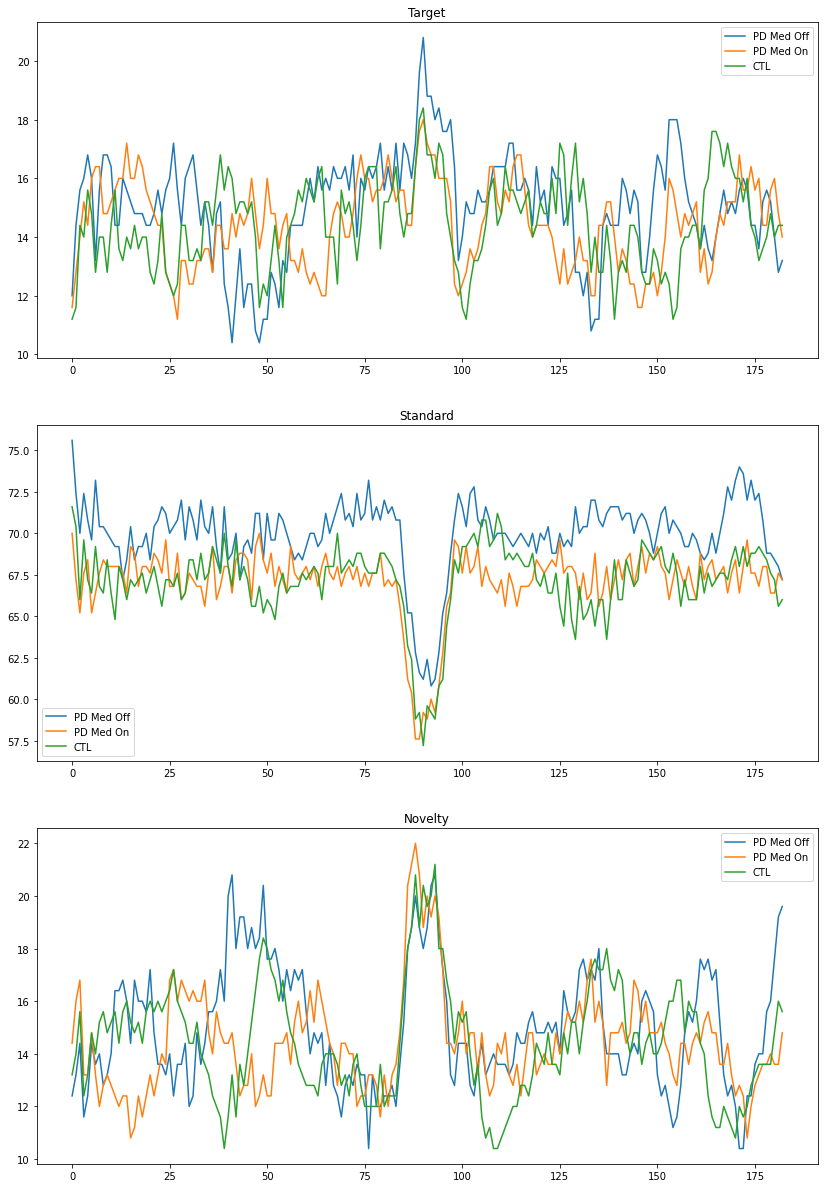

In [27]:
N = 10
conv_sub_stims = np.zeros((75, 192 - N + 1))
window = np.ones((N, )) / N * 100

fig, axs = plt.subplots(3, 1, figsize=(14, 21))

for k in range(3):
    for i in range(df.shape[0]):
        if len(df.iloc[i].stim) < 192:
            continue
        stim = np.array(df.iloc[i].stim[:192]) - 5
        conv_sub_stims[i] = np.convolve(stim == k, window, 'valid')

    for i in range(3):
        axs[k].plot(conv_sub_stims[df.pd_drug_type == i].
                    mean(axis=0), label=groups[i])
    axs[k].set_title(event_types[k])
    axs[k].legend()
plt.show()


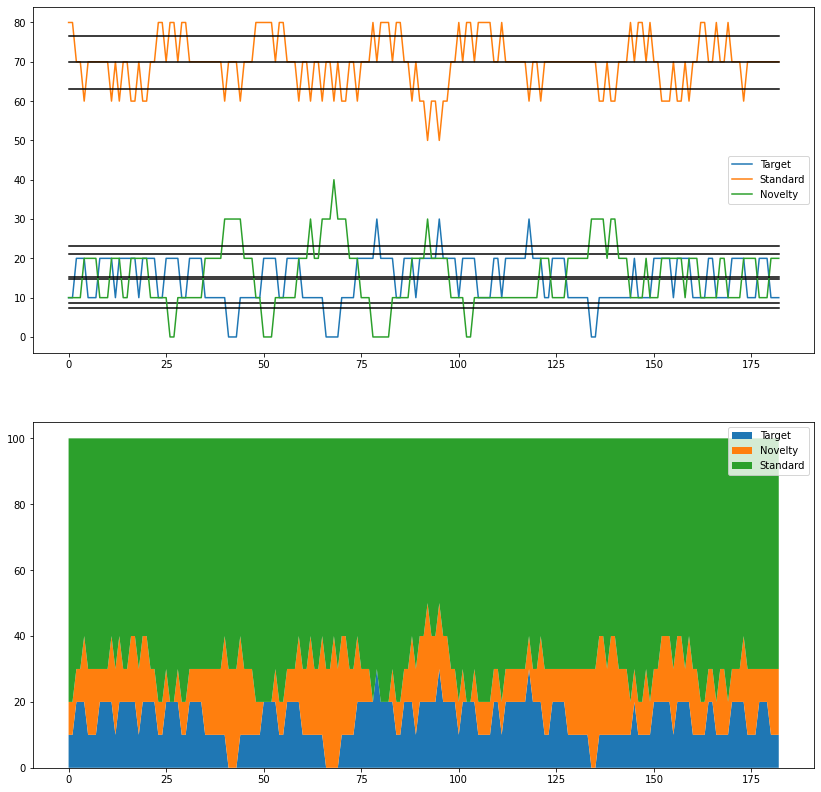

In [65]:
N = 10
conv_sub_stims = np.zeros((3, 192 - N + 1))
window = np.ones((N, )) / N * 100
# window = np.zeros((N, ))
# omega = 4
# for i in range(N):
#     window[i] = np.exp((9 - i) / omega)
# window /= window.sum() / 100

fig, axs = plt.subplots(2, 1, figsize=(14, 14))

for k in range(3):
    # for i in range(df.shape[0]):
    if 1:
        sub = 10
        if len(df.iloc[sub].stim) < 192:
            continue
        stim = np.array(df.iloc[i].stim[:192]) - 5
        conv_sub_stims[k] = np.convolve(stim == k, window, 'valid')

    axs[0].plot(conv_sub_stims[k],
                label=event_types[k])
    axs[0].plot([0, 192-N], [conv_sub_stims.mean(axis=1)
                [k], conv_sub_stims.mean(axis=1)[k]], 'k')
    axs[0].plot([0, 192-N], [conv_sub_stims.mean(axis=1)[k] + conv_sub_stims.std(axis=1)[k],
                             conv_sub_stims.mean(axis=1)[k] + conv_sub_stims.std(axis=1)[k]], 'k')

    axs[0].plot([0, 192-N], [conv_sub_stims.mean(axis=1)[k] - conv_sub_stims.std(axis=1)[k],
                             conv_sub_stims.mean(axis=1)[k] - conv_sub_stims.std(axis=1)[k]], 'k')

axs[0].legend()

axs[1].stackplot(range(192 - N + 1), conv_sub_stims[0],
                 conv_sub_stims[2], conv_sub_stims[1],
                 labels=[event_types[0], event_types[2], event_types[1]])
axs[1].legend()
plt.show()


In [56]:
p(x == a) - -> .15
p(x[0:10] != a)


array([15., 15., 15., 20., 20., 15., 15., 15., 15., 20., 20., 20., 15.,
       15., 15., 20., 20., 20., 15., 15., 15., 20., 20., 15., 15., 15.,
       15., 15., 15., 10., 10., 10., 10., 10., 15., 10., 10., 10., 10.,
       10., 15., 10., 10., 10., 10., 10., 15., 15., 15., 15., 15., 15.,
       15., 15., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 15.,
       15., 10., 10., 10., 15., 15., 15., 15., 15., 15., 15., 20., 20.,
       20., 20., 20., 20., 20., 20., 15., 20., 20., 20., 20., 15., 15.,
       20., 20., 20., 20., 20., 15., 15., 15., 20., 15., 15., 20., 20.,
       20., 15., 15., 15., 20., 20., 20., 15., 15., 15., 20., 20., 20.,
       20., 20., 15., 15., 15., 10., 10., 10., 10., 15., 15., 10., 10.,
       10., 10., 10., 10.,  5., 10., 10., 10., 10., 10., 15., 15., 15.,
       15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 20., 15.,
       15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 10., 15., 15.,
       15., 15., 15., 15.])

In [61]:
0.85**10


0.1968744043407226

In [62]:
conv_sub_stims.mean(axis=1)


array([14.80874317, 69.83606557, 15.35519126])

In [ ]:
['F3', 'F4', 'FC3', 'FC4', 'Fz', 'Pz']

[
    ('Fz', 'FC3'), ('Fz', 'FC4'), 
    ('Pz', 'FC3'), ('Pz', 'FC4'), 
    ('Fz', 'F3'), ('Fz', 'F4'),
    ('Pz', 'F3'), ('Pz', 'F4'),
]

gamma = [33, 34, 35, 36]
beta = [5, 6, 7, 8]
